# Temporal Generalization Decoding
## Use YBN only; linear SVM; feature: NBG activity from all visual electrodes

In [1]:
import os
import scipy.io as sio
import mat73
import numpy as np
from DecodingBasic import DataBasic
from functools import reduce
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

In [2]:
# subject info
sbj_name = 'YBN'
contrast_blk = ['037']
gamma_blk    = ['006']
recall_blk   = ['038', '039', '040']
tone_blk     = ['036']

# home directory
home_path = '~/Documents/MATLAB/ECoG'
home_dir  = os.path.expanduser(home_path)

In [3]:
# initiate decoding data object
train_contrast_obj = DataBasic(sbj_name, contrast_blk,'vis_contrast_only')
train_recall_obj   = DataBasic(sbj_name, recall_blk,'vis_contrast_recall')
train_gamma_obj    = DataBasic(sbj_name, gamma_blk,'vis_contrast_gamma')
test_recall_obj    = DataBasic(sbj_name, recall_blk,'vis_contrast_recall')
test_tone_obj      = DataBasic(sbj_name, tone_blk,'vis_tone_only')

In [4]:
# get electrode list
elec_vis_list  = train_contrast_obj.elec_record('vis') # visual cortex electrodes
elec_resp_list = train_contrast_obj.elec_record('resp') # visual responsive electrodes

In [5]:
# frequency band that we are interested in
band_NBG = [20, 60]

## Extract data
Feature matrix: trials * electrodes, element is mean NBG value of a given 50 ms time bin.  
Label vector: contrast level, recoded into 0,1,2.

In [158]:
# extract training data and testing data, apply normalization
count_ci = 0 
for ci in elec_resp_list:
    
    # ~~~training data~~~~
    
    # extract spectral data and compute band average value
    train_contrast_spect, label_train_contrast, _ = train_contrast_obj.extract_training_data(ci)    
    train_recall_spect,   label_train_recall, _   = train_recall_obj.extract_training_data(ci)
    train_gamma_spect,    label_train_gamma, _    = train_gamma_obj.extract_training_data(ci)

    train_contrast_NBG = train_contrast_obj.get_band_value(band_NBG, train_contrast_spect, ci)
    train_recall_NBG   = train_recall_obj.get_band_value(band_NBG, train_recall_spect, ci)
    train_gamma_NBG    = train_gamma_obj.get_band_value(band_NBG, train_gamma_spect, ci)
    
    training_data = np.concatenate((train_contrast_NBG, train_recall_NBG, train_gamma_NBG), axis = 0)
    training_data = training_data[:,1000:1500]
    
    # normalization
    m = np.mean(training_data)
    z = np.std(training_data)
    training_data = (training_data - m)/z
    
    # ~~~~testing data~~~~
    
    # extract
    test_recall_spect,    label_test_recall, _    = test_recall_obj.extract_testing_data(ci)
    test_tone_spect,      label_test_tone, _      = test_tone_obj.extract_testing_data(ci)
    
    test_recall_NBG = test_recall_obj.get_band_value(band_NBG, test_recall_spect, ci)
    test_tone_NBG   = test_tone_obj.get_band_value(band_NBG, test_tone_spect, ci)
    
    testing_data = test_recall_NBG[:,1000:4000]
    control_data = test_tone_NBG[:,1000:4000]
    
    # normalization
    testing_data = (testing_data - m)/z
    control_data = (control_data - m)/z
    
    # ~~~~append data~~~~~
    training_data = np.expand_dims(training_data, axis = 0)
    testing_data  = np.expand_dims(testing_data, axis = 0)
    control_data  = np.expand_dims(control_data, axis = 0)
    
    if count_ci == 0:
        training_all = training_data
        testing_all  = testing_data
        control_all  = control_data
        
    else:
        training_all = np.append(training_all, training_data, axis = 0)
        testing_all  = np.append(testing_all,  testing_data,  axis = 0)
        control_all  = np.append(control_all,  control_data,  axis = 0)
    
    # ~~~~~extract label~~~~~
    training_label = np.concatenate((label_train_contrast, label_train_recall, label_train_gamma))
    testing_label = label_test_recall
    control_label = label_test_tone
    
    count_ci += 1
    

In [160]:
# recode label
le = LabelEncoder()
le.fit(training_label)
y_train = le.transform(training_label)
y_test = le.transform(testing_label)
y_control = le.transform(control_label)

## Analysis

### 1. Decoding validation

Classifiers were trained with training data and tested on the training data (training data = data with grating stimulus visually presented) in a temporal manner (time bin = 50ms). 

In [201]:
ACC_mx = np.zeros((10,10)) # matrix storing accuracy
p_mx = np.zeros((10,10)) # matrix storing p-values
permutation_score_mx = [] # permutation scores of diagonal time windows, 
                          # they can be used to calculate p-values for off-diagonal decoding
for i in range(10):
    
    for j in range(10):
        ind_i = 50*i
        ind_j = 50*j
        training_mx = np.mean(training_all[:,:,ind_i:(ind_i+50)], axis = 2)
        testing_mx  = np.mean(training_all[:,:,ind_j:(ind_j+50)], axis = 2)
        
        if i == j:
            X = training_mx.T
            y = y_train
            svm = SVC(kernel='linear')
            cv = StratifiedKFold(10)
            score, permutation_scores, pvalue = permutation_test_score(\
                   svm, X, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)
            
            permutation_score_mx.append(permutation_scores)
            ACC_mx[i,j] = score
            p_mx[i,j] = pvalue
        else:
            X_train = training_mx.T
            X_test = testing_mx.T
            
            svm = SVC(kernel='linear')
            svm.fit(X_train,y_train)
            ACC_mx[i,j] = np.mean(svm.predict(X_test)==y_train)
            

### Result

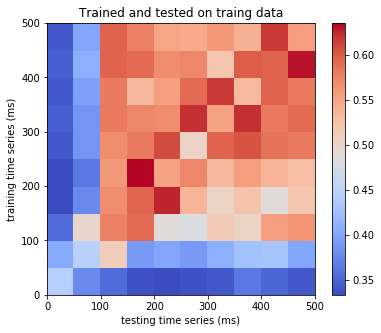

In [206]:
fig, ax = plt.subplots(figsize = (6,5))
plt.pcolormesh(ACC_mx, cmap = 'coolwarm')
plt.colorbar()
plt.ylabel('training time series (ms)');
plt.xlabel('testing time series (ms)');
plt.xticks([0,2,4,6,8,10],[0,100,200,300,400,500]);
plt.yticks([0,2,4,6,8,10],[0,100,200,300,400,500]);
plt.title('Trained and tested on traing data');

### 2. Temporal Generalization 1: Train on training data and test on testing/control data
In a temporal manner, classifiers were trained on the training data (trials with visually presented grating), and then tested on the delay period of vis_contrast_recall and vis_tone_only, respectively.

In [173]:
# Tested on testing data (contrast recall)
temporal_ACC_mx = np.zeros((10,60))

for i in range(10):
    for j in range(60):
        ind_i = 50*i
        ind_j = 50*j
        
        training_mx = np.mean(training_all[:,:,ind_i:(ind_i+50)], axis = 2).T
        testing_mx  = np.mean(testing_all[:,:,ind_j:(ind_j+50)], axis = 2).T
        
        svm = SVC(kernel='linear')
        svm.fit(training_mx, y_train)
        temporal_ACC_mx[i,j] = np.mean(svm.predict(testing_mx)==y_test)

In [207]:
print('Range of the accuracy: [{},{}]'.format(np.min(temporal_ACC_mx),np.max(temporal_ACC_mx)))

Range of the accuracy: [0.3,0.36666666666666664]


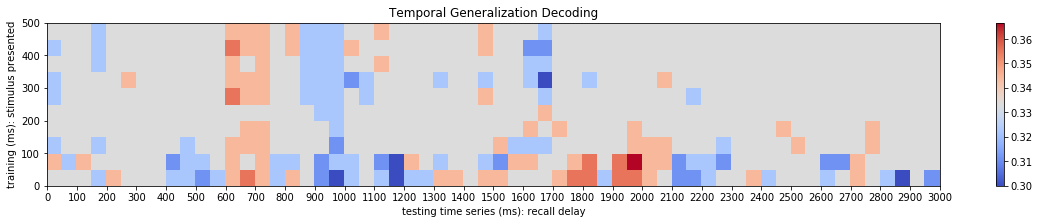

In [210]:
# plot
fig, ax = plt.subplots(figsize = (20,3))
plt.pcolormesh(temporal_ACC_mx, cmap = 'coolwarm')
plt.colorbar()
plt.xlabel('testing time series (ms): recall delay');
plt.ylabel('training (ms): stimulus presented');
plt.title('Temporal Generalization Decoding')
plt.xticks(np.arange(0,61,2),np.arange(0,30001,100));
plt.yticks([0,2,4,6,8,10],[0,100,200,300,400,500]);

In [212]:
# Tested on control data (tone only)
control_ACC_mx = np.zeros((10,60))

for i in range(10):
    for j in range(60):
        ind_i = 50*i
        ind_j = 50*j
        
        training_mx = np.mean(training_all[:,:,ind_i:(ind_i+50)], axis = 2).T
        testing_mx  = np.mean(control_all[:,:,ind_j:(ind_j+50)], axis = 2).T
        
        svm = SVC(kernel='linear')
        svm.fit(training_mx, y_train)
        control_ACC_mx[i,j] = np.mean(svm.predict(testing_mx)==y_control)

In [213]:
print('Range of the accuracy: [{},{}]'.format(np.min(control_ACC_mx),np.max(control_ACC_mx)))

Range of the accuracy: [0.3,0.36666666666666664]


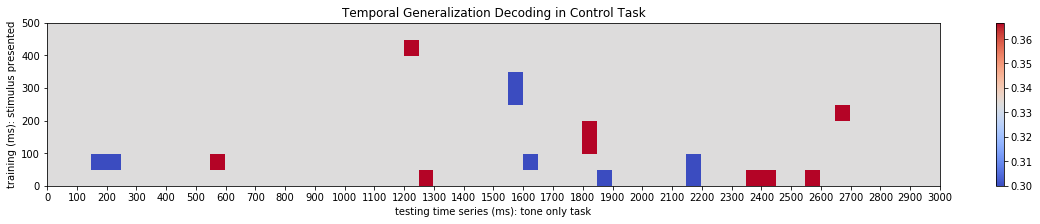

In [214]:
fig, ax = plt.subplots(figsize = (20,3))
plt.pcolormesh(control_ACC_mx, cmap = 'coolwarm')
plt.colorbar()
plt.xlabel('testing time series (ms): tone only task');
plt.ylabel('training (ms): stimulus presented');
plt.title('Temporal Generalization Decoding in Control Task');
plt.xticks(np.arange(0,61,2),np.arange(0,30001,100));
plt.yticks([0,2,4,6,8,10],[0,100,200,300,400,500]);

### 3. Temporal Generalization 2: Train on delay and test on delay within the same task
Two result figures are using the same colorbar scale.

In [183]:
self_ACC_mx = np.zeros((60,60))
self_p_mx = np.zeros((60,60))
permutation_self_mx = []
for i in range(60):
    
    for j in range(60):
        ind_i = 50*i
        ind_j = 50*j
        training_mx = np.mean(testing_all[:,:,ind_i:(ind_i+50)], axis = 2)
        testing_mx  = np.mean(testing_all[:,:,ind_j:(ind_j+50)], axis = 2)
        
        if i == j:
            X = training_mx.T
            y = y_test
            svm = SVC(kernel='linear')
            cv = StratifiedKFold(10)
            score, permutation_scores, pvalue = permutation_test_score(\
                   svm, X, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)
            
            permutation_self_mx.append(permutation_scores)
            self_ACC_mx[i,j] = score
            self_p_mx[i,j] = pvalue
        else:
            X_train = training_mx.T
            X_test = testing_mx.T
            
            svm = SVC(kernel='linear')
            svm.fit(X_train,y_test)
            self_ACC_mx[i,j] = np.mean(svm.predict(X_test)==y_test)

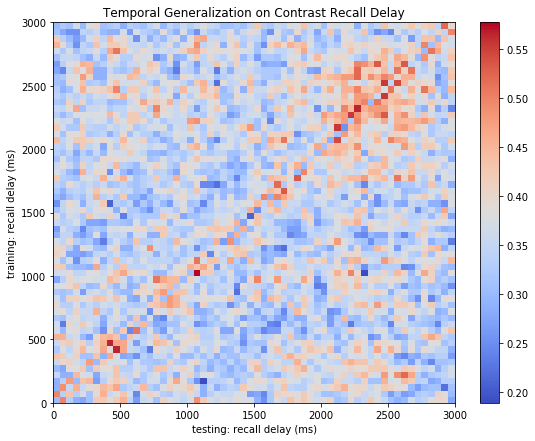

In [223]:
fig, ax = plt.subplots(figsize = (9,7))
plt.pcolormesh(self_ACC_mx, cmap = 'coolwarm')
plt.colorbar()
plt.ylabel('training: recall delay (ms)');
plt.xlabel('testing: recall delay (ms)');
plt.title('Temporal Generalization on Contrast Recall Delay');
plt.xticks(np.arange(0,61,10),np.arange(0,30001,500));
plt.yticks(np.arange(0,61,10),np.arange(0,30001,500));

In [186]:
self_control_ACC_mx = np.zeros((60,60))
self_control_p_mx = np.zeros((60,60))
permutation_self_control_mx = []
for i in range(60):
    
    for j in range(60):
        ind_i = 50*i
        ind_j = 50*j
        training_mx = np.mean(control_all[:,:,ind_i:(ind_i+50)], axis = 2)
        testing_mx  = np.mean(control_all[:,:,ind_j:(ind_j+50)], axis = 2)
        
        if i == j:
            X = training_mx.T
            y = y_control
            svm = SVC(kernel='linear')
            cv = StratifiedKFold(10)
            score, permutation_scores, pvalue = permutation_test_score(\
                   svm, X, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)
            
            permutation_self_control_mx.append(permutation_scores)
            self_control_ACC_mx[i,j] = score
            self_control_p_mx[i,j] = pvalue
        else:
            X_train = training_mx.T
            X_test = testing_mx.T
            
            svm = SVC(kernel='linear')
            svm.fit(X_train,y_control)
            self_control_ACC_mx[i,j] = np.mean(svm.predict(X_test)==y_control)

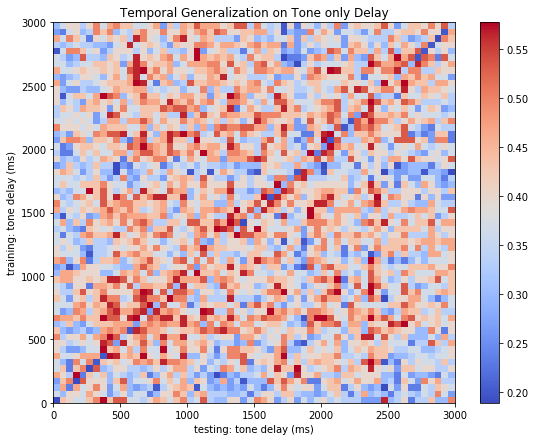

In [224]:
fig, ax = plt.subplots(figsize = (9,7))
plt.pcolormesh(self_control_ACC_mx, cmap = 'coolwarm', vmin = np.min(self_ACC_mx), vmax = np.max(self_ACC_mx))
plt.colorbar()
plt.ylabel('training: tone delay (ms)');
plt.xlabel('testing: tone delay (ms)');
plt.title('Temporal Generalization on Tone only Delay');
plt.xticks(np.arange(0,61,10),np.arange(0,30001,500));
plt.yticks(np.arange(0,61,10),np.arange(0,30001,500));